## Problem Statement

Dataset that I am working with, contains records of AirBnB bookings from Seattle. The link can be found here : 
https://www.kaggle.com/airbnb/seattle

I am specifically working with the listings.csv file. The intent is to predict the business a property listed on AirBnB will generate. But since there is no such variable in the dataset, I will be using 'Reviews per month' as a proxy for the same. The assumption here is that total reviews garnered by a listing, is directly proportional to the number of bookings generated.

In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Reading in the datasets

listings = pd.read_csv('/Users/hafiznadirshah/Desktop/Hafiz/Data_Science/AirBnB dataset/listings.csv')
calendar = pd.read_csv('/Users/hafiznadirshah/Desktop/Hafiz/Data_Science/AirBnB dataset/calendar.csv')
reviews = pd.read_csv('/Users/hafiznadirshah/Desktop/Hafiz/Data_Science/AirBnB dataset/reviews.csv')

In [5]:
# Checking the columns

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [6]:
# Dropping the columns that won't affect the ratings - a mix of intuition and educated guesses
# Dropping columns with repetition and not enough relevant data
# Also removing the comments section, since I do not intend to do sentiment analysis

properties = listings.copy()

properties.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview', 
                'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 
                 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                'host_verifications', 'street', 'neighbourhood', 'city', 'state', 'zipcode',
                 'market', 'smart_location', 'country_code', 'country', 'has_availability',
                'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 'id', 'host_id', 'host_acceptance_rate', 'host_total_listings_count', 'host_has_profile_pic', 
         'neighbourhood_cleansed', 'amenities', 'square_feet', 'first_review', 'last_review'], axis=1, inplace=True)

In [7]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        3816 non-null   object 
 1   host_response_time                3295 non-null   object 
 2   host_response_rate                3295 non-null   object 
 3   host_is_superhost                 3816 non-null   object 
 4   host_listings_count               3816 non-null   float64
 5   host_identity_verified            3816 non-null   object 
 6   neighbourhood_group_cleansed      3818 non-null   object 
 7   latitude                          3818 non-null   float64
 8   longitude                         3818 non-null   float64
 9   is_location_exact                 3818 non-null   object 
 10  property_type                     3817 non-null   object 
 11  room_type                         3818 non-null   object 
 12  accomm

In [8]:
# dropping rows which do not have the target variable

properties.dropna(subset=['reviews_per_month'], inplace=True)
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191 entries, 0 to 3814
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        3191 non-null   object 
 1   host_response_time                2871 non-null   object 
 2   host_response_rate                2871 non-null   object 
 3   host_is_superhost                 3191 non-null   object 
 4   host_listings_count               3191 non-null   float64
 5   host_identity_verified            3191 non-null   object 
 6   neighbourhood_group_cleansed      3191 non-null   object 
 7   latitude                          3191 non-null   float64
 8   longitude                         3191 non-null   float64
 9   is_location_exact                 3191 non-null   object 
 10  property_type                     3191 non-null   object 
 11  room_type                         3191 non-null   object 
 12  accomm

In [9]:
# filling missing host_response_time with random values

fill_list = ['within a few hours', 'within an hour', 'within a day', 'a few days or more']
mask = properties['host_response_time'].isnull()
nulls_length = mask.sum()
filled_values = np.random.choice(fill_list, size=nulls_length)

properties.loc[mask, 'host_response_time'] = filled_values

In [10]:
# changing host response rate

properties['host_response_rate'] = properties['host_response_rate'].str.replace('%', '').astype(float)
properties['host_response_rate'] = properties['host_response_rate']/100

mask_rr = properties['host_response_rate'].isnull()
properties.loc[mask_rr, 'host_response_rate'] = properties['host_response_rate'].mean()

In [11]:
# filling missing bathrooms and bedrooms values with most dominant number - 1

properties.loc[properties['bathrooms'].isnull(), 'bathrooms'] = 1
properties.loc[properties['bedrooms'].isnull(), 'bedrooms'] = 1

In [12]:
# filling missing values of weekly, monthly price, security deposit, cleaning fee
# with multiples 6.5, 21.5, 2 and 0.4 on price - the mean multiple on price

properties['price'] = properties['price'].str.replace('$', '')
properties['price'] = properties['price'].str.replace(',', '').astype(float)

properties['weekly_price'] = properties['weekly_price'].str.replace('$', '')
properties['weekly_price'] = properties['weekly_price'].str.replace(',', '').astype(float)

properties['monthly_price'] = properties['monthly_price'].str.replace('$', '')
properties['monthly_price'] = properties['monthly_price'].str.replace(',', '').astype(float)

properties['security_deposit'] = properties['security_deposit'].str.replace('$', '')
properties['security_deposit'] = properties['security_deposit'].str.replace(',', '').astype(float)

properties['cleaning_fee'] = properties['cleaning_fee'].str.replace('$', '')
properties['cleaning_fee'] = properties['cleaning_fee'].str.replace(',', '').astype(float)


properties.loc[properties['weekly_price'].isnull(), 'weekly_price'] = properties.loc[properties['weekly_price'].isnull(), 'price'] * 6.5
properties.loc[properties['monthly_price'].isnull(), 'monthly_price'] = properties.loc[properties['monthly_price'].isnull(), 'price'] * 21.5
properties.loc[properties['security_deposit'].isnull(), 'security_deposit'] = properties.loc[properties['security_deposit'].isnull(), 'price'] * 2
properties.loc[properties['cleaning_fee'].isnull(), 'cleaning_fee'] = properties.loc[properties['cleaning_fee'].isnull(), 'price'] * 0.4


In [13]:
# converting extra_people into number

properties['extra_people'] = properties['extra_people'].str.replace('$', '').astype(float)

In [14]:
# changing the host_since column to numeric value - no. of days from today

properties['host_since'] = pd.to_datetime(properties['host_since'])

from datetime import datetime
properties['host_since'] = properties['host_since'].apply(lambda x: (datetime.now() - x).days)

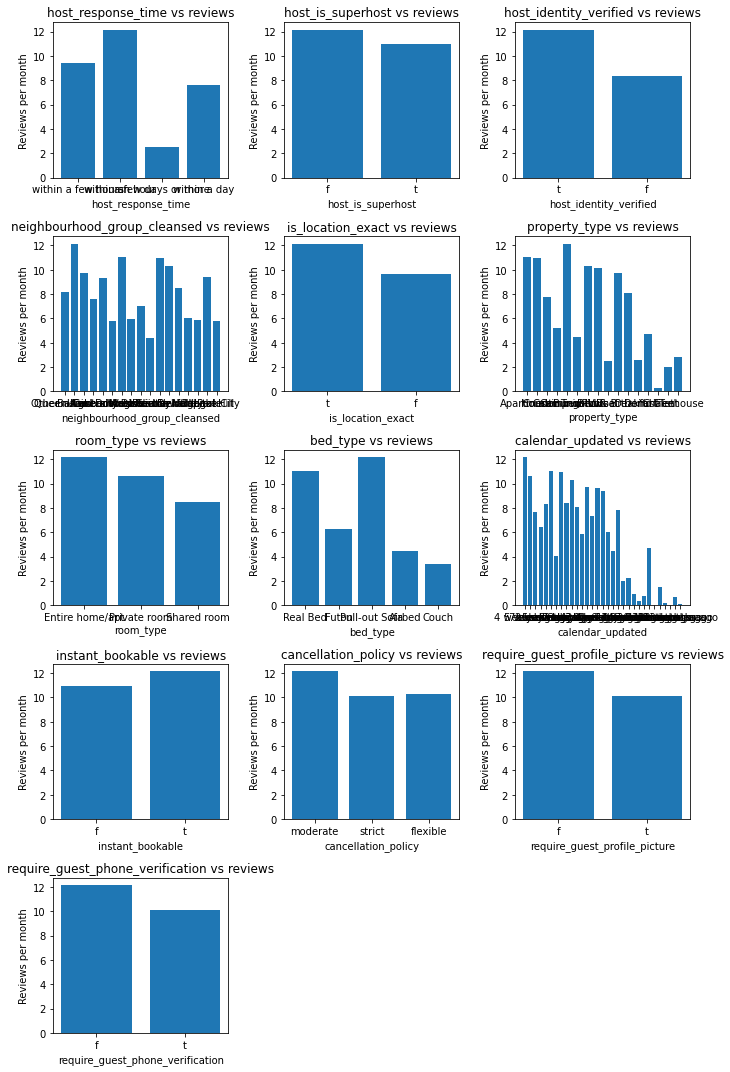

In [15]:
# Checking whether there is a meaningful difference in reviews_per_month between classes of categorical variables

categorical_cols = properties.select_dtypes(['object']).columns

plt.figure(figsize=(10, 15))
for i, col in enumerate(categorical_cols):
    plt.subplot(5, 3, i+1)
    plt.bar(properties[col], properties['reviews_per_month'])
    plt.title(f'{col} vs reviews')
    plt.xlabel(f'{col}')
    plt.ylabel('Reviews per month')
    plt.tight_layout()    

plt.show()

### There looks to be a difference between classes, so not dropping any.

### Checking to see whethere there are classes with very low number of observations

In [16]:
for col in categorical_cols:
    
    categories = properties[col].unique()
    print(f"For column : {col}")
    print('---------------------')
    for cat in categories:
        print(f"Number of rows for {cat} is : {len(properties[properties[col] == cat])}")
    print('\n')

For column : host_response_time
---------------------
Number of rows for within a few hours is : 917
Number of rows for within an hour is : 1609
Number of rows for a few days or more is : 101
Number of rows for within a day is : 564


For column : host_is_superhost
---------------------
Number of rows for f is : 2440
Number of rows for t is : 751


For column : host_identity_verified
---------------------
Number of rows for t is : 2617
Number of rows for f is : 574


For column : neighbourhood_group_cleansed
---------------------
Number of rows for Queen Anne is : 248
Number of rows for Ballard is : 193
Number of rows for Other neighborhoods is : 664
Number of rows for Cascade is : 65
Number of rows for Central Area is : 320
Number of rows for University District is : 98
Number of rows for Downtown is : 458
Number of rows for Magnolia is : 47
Number of rows for West Seattle is : 164
Number of rows for Interbay is : 9
Number of rows for Beacon Hill is : 103
Number of rows for Rainier Va

Dropping the following categories with low observations < 10, after one-hot encoding:

- neighbourhood_group_cleansed : Interbay
- property_type : Bungalow, Boat, Dorm, Yurt, Chalet, Tent, Treehouse
- bed_type : Couch
- calendar_updated : never, 10 months ago, 14 months ago, 30 months ago, 9 months ago, 11 months ago, 22 months ago, 12 months ago, 13 months ago

Encoding as 1-0, the following columns, instead of one-hpt encoding, due to binary categories :

- host_is_superhost, host_identity_verified, is_location_exact, instant_bookable, require_guest_profile_picture, require_guest_phone_verification

In [17]:
# Changing binary variables to single

properties['host_is_superhost'] = np.where(properties['host_is_superhost'] =='t', 1, 0)
properties['host_identity_verified'] = np.where(properties['host_identity_verified'] == 't', 1, 0)
properties['is_location_exact'] = np.where(properties['is_location_exact'] == 't', 1, 0)
properties['instant_bookable'] = np.where(properties['instant_bookable'] == 't', 1, 0)
properties['require_guest_profile_picture'] = np.where(properties['require_guest_profile_picture'] == 't', 1, 0)
properties['require_guest_phone_verification'] = np.where(properties['require_guest_phone_verification'] == 't', 1, 0)

In [18]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191 entries, 0 to 3814
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        3191 non-null   int64  
 1   host_response_time                3191 non-null   object 
 2   host_response_rate                3191 non-null   float64
 3   host_is_superhost                 3191 non-null   int64  
 4   host_listings_count               3191 non-null   float64
 5   host_identity_verified            3191 non-null   int64  
 6   neighbourhood_group_cleansed      3191 non-null   object 
 7   latitude                          3191 non-null   float64
 8   longitude                         3191 non-null   float64
 9   is_location_exact                 3191 non-null   int64  
 10  property_type                     3191 non-null   object 
 11  room_type                         3191 non-null   object 
 12  accomm

In [19]:
# one-hot encoding the other variables and creating the predictor and target variables

categorical_cols = properties.select_dtypes(['object']).columns
X = pd.get_dummies(properties, prefix=categorical_cols).drop(['reviews_per_month'], axis=1)
y = properties['reviews_per_month']

In [20]:
# Dropping the following categories with low observations < 10, as determined a couple of steps above

X.drop(['neighbourhood_group_cleansed_Interbay', 'property_type_Boat', 'property_type_Bungalow', 'property_type_Dorm', 
       'property_type_Yurt', 'property_type_Chalet', 'property_type_Tent', 'property_type_Treehouse', 'bed_type_Couch', 
       'calendar_updated_never', 'calendar_updated_10 months ago', 'calendar_updated_14 months ago', 
       'calendar_updated_30 months ago', 'calendar_updated_9 months ago', 'calendar_updated_11 months ago', 
       'calendar_updated_22 months ago', 'calendar_updated_12 months ago', 'calendar_updated_13 months ago'], 
       axis=1, inplace=True)

## Checking for normality of continuous variables

In [21]:
numerical_cols = properties.select_dtypes(['int64', 'float64']).columns

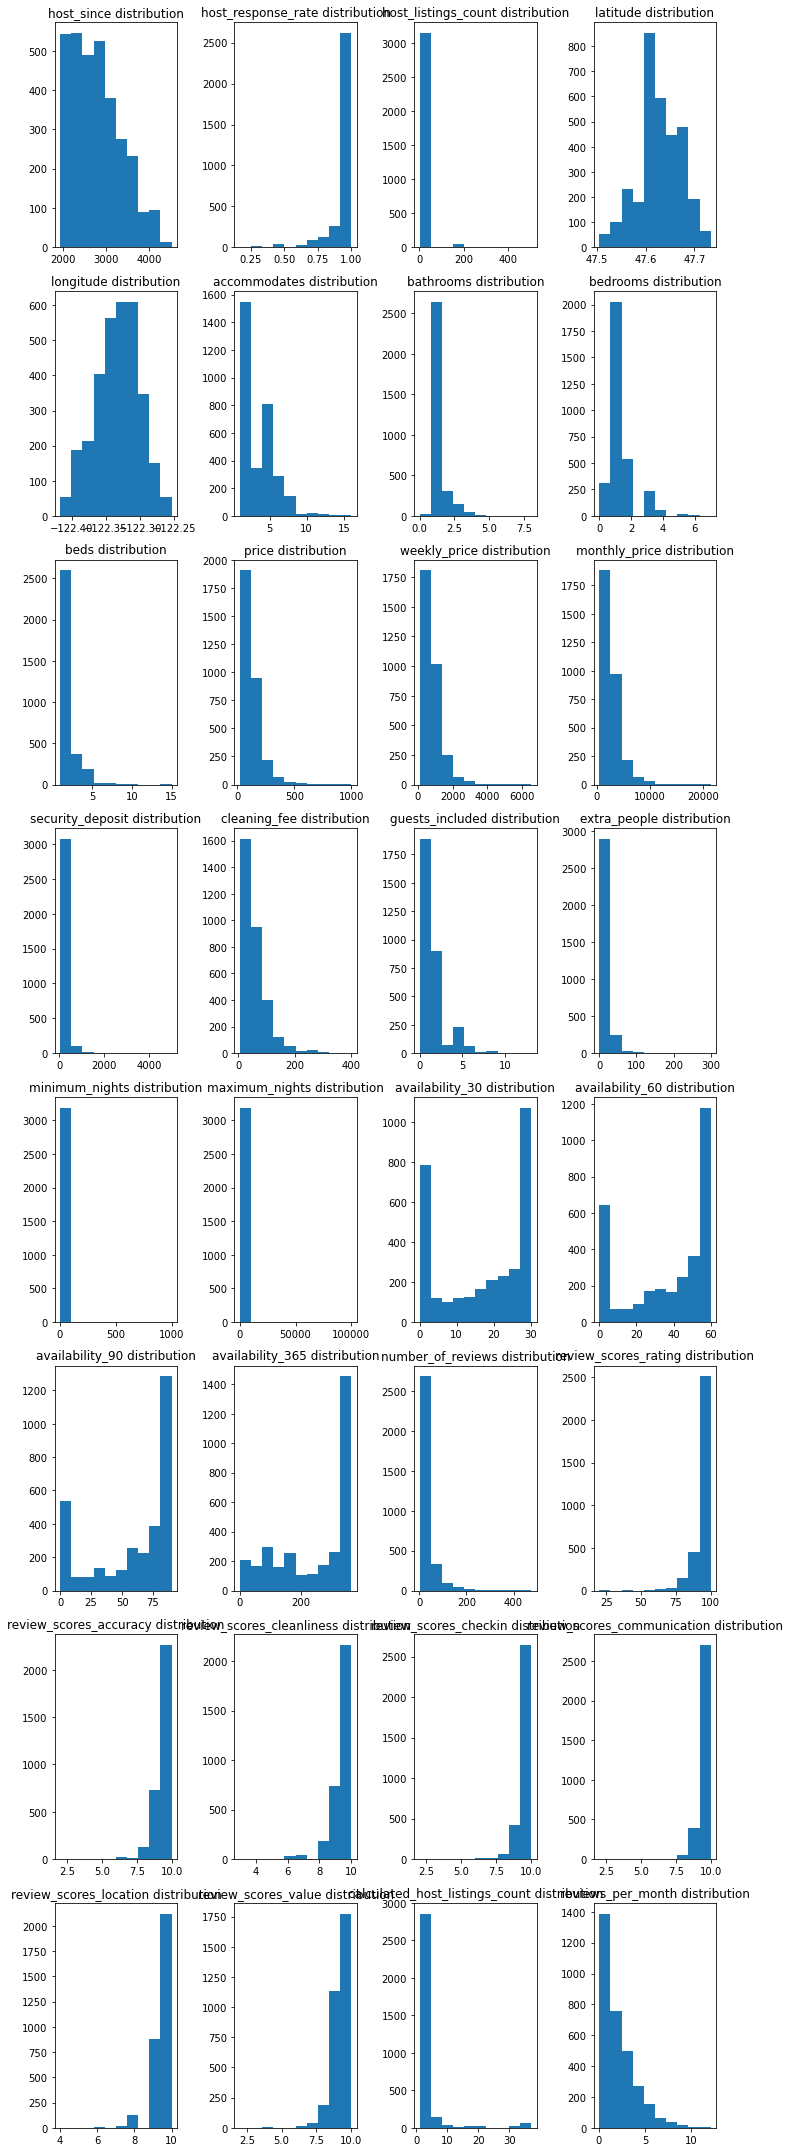

In [82]:
plt.figure(figsize=(10, 30))

for i, col in enumerate(numerical_cols):
    plt.subplot(8, 4, i+1)
    plt.hist(one[col])
    plt.title(f'{col} distribution')
    plt.tight_layout()

plt.show()

### Tried some log transofrmations - but they either have negative values, or do not approach normal distributions. So not transforming any of these variables.

### Checking for correlation between the review scores

In [22]:
properties[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']].corr()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
review_scores_rating,1.000000,0.621257,0.642882,0.521813,0.540620,0.368423,0.696534,0.087313
review_scores_accuracy,0.621257,1.000000,0.543345,0.407238,0.423189,0.267605,0.562878,0.143613
review_scores_cleanliness,0.642882,0.543345,1.000000,0.398696,0.388146,0.277834,0.524354,0.133974
review_scores_checkin,0.521813,0.407238,0.398696,1.000000,0.696345,0.240903,0.403263,0.123107
review_scores_communication,0.540620,0.423189,0.388146,0.696345,1.000000,0.284635,0.463772,0.104313
review_scores_location,0.368423,0.267605,0.277834,0.240903,0.284635,1.000000,0.368252,0.062151
review_scores_value,0.696534,0.562878,0.524354,0.403263,0.463772,0.368252,1.000000,0.126014
reviews_per_month,0.087313,0.143613,0.133974,0.123107,0.104313,0.062151,0.126014,1.000000


In [23]:
# It is weak-to-moderate correlation. Hence they all will be retained
# Filling in the missing values with the mean

X.loc[X['review_scores_rating'].isnull(), 'review_scores_rating'] = X['review_scores_rating'].mean()
X.loc[X['review_scores_accuracy'].isnull(), 'review_scores_accuracy'] = X['review_scores_accuracy'].mean()
X.loc[X['review_scores_cleanliness'].isnull(), 'review_scores_cleanliness'] = X['review_scores_cleanliness'].mean()
X.loc[X['review_scores_checkin'].isnull(), 'review_scores_checkin'] = X['review_scores_checkin'].mean()
X.loc[X['review_scores_communication'].isnull(), 'review_scores_communication'] = X['review_scores_communication'].mean()
X.loc[X['review_scores_location'].isnull(), 'review_scores_location'] = X['review_scores_location'].mean()
X.loc[X['review_scores_value'].isnull(), 'review_scores_value'] = X['review_scores_value'].mean()


## Moving on to testing out different models

### 1. Trying Linear Regression


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [25]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

predictions_lr = lr.predict(X_test)

print(f"R-squared on training data is : {lr.score(X_train, y_train)}")
print(f"R-squared on test data is : {lr.score(X_test, y_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y_test, predictions_lr)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y_test, predictions_lr))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y_test, predictions_lr)}')

R-squared on training data is : 0.575967190634747
R-squared on test data is : 0.47079441477555717 

Mean absolute error is : 0.930490164029902
Root mean squared error is : 1.38108221874646
Mean Absolute percentage error is : 0.9491388934878531


In [26]:
# Trying cross-validation to test the stability of the model

from sklearn.model_selection import cross_val_score
lr_crossval = linear_model.LinearRegression()
cross_val_lr = cross_val_score(lr_crossval, X, y, cv=10)

print(cross_val_lr)
print(cross_val_lr.mean())
print(cross_val_lr.std())

[ 0.56777291  0.50220602  0.60093956  0.30982034  0.50183051  0.46978617
 -0.90809315  0.54908389  0.48276147  0.51696615]
0.35930738609844476
0.42891115730435886


### The standard deviation is very high, indicating that the model is not very stable
### The R-squared is fairly low, indicating that the model explains only about 47% of the variation in the target variable

In [27]:
# Extracting the coefficients

coeff_comparison = pd.DataFrame()
coeff_comparison['LR coefficients'] = lr.coef_
coeff_comparison.index = X.columns

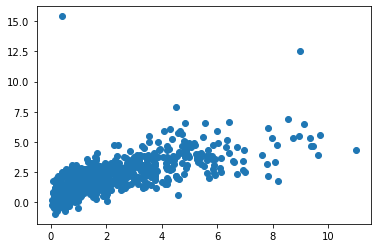

In [28]:
# Checking the actual vs predicted outcomes

plt.scatter(y_test, predictions_lr);

### 2. Trying a Decision Tree

In [29]:
from sklearn import tree

dt = tree.DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)

predictions_dt = dt.predict(X_test)

print(f"R-squared of training data is : {dt.score(X_train, y_train)}")
print(f"R-squared of test data is : {dt.score(X_test, y_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y_test, predictions_dt)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y_test, predictions_dt))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y_test, predictions_dt)}')

R-squared of training data is : 0.5708005480485525
R-squared of test data is : 0.5073784111488955 

Mean absolute error is : 0.9256884738686312
Root mean squared error is : 1.3324902643222656
Mean Absolute percentage error is : 0.8488368267524278


In [30]:
# Doing a cross-validation

dt_crossval = tree.DecisionTreeRegressor(max_depth=4)
cross_val_dt = cross_val_score(dt_crossval, X, y, cv=10)

print(cross_val_dt)
print(cross_val_dt.mean())
print(cross_val_dt.std())

[0.57091171 0.48272329 0.59105389 0.5523439  0.40503236 0.41349621
 0.53133772 0.46337815 0.44526094 0.48179531]
0.4937333478521303
0.06173952255707871


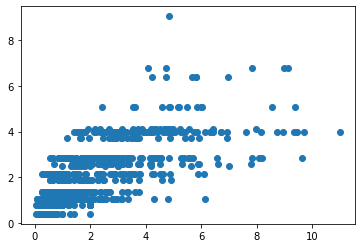

In [31]:
# Plotting the actual and predicted values

plt.scatter(y_test, predictions_dt);

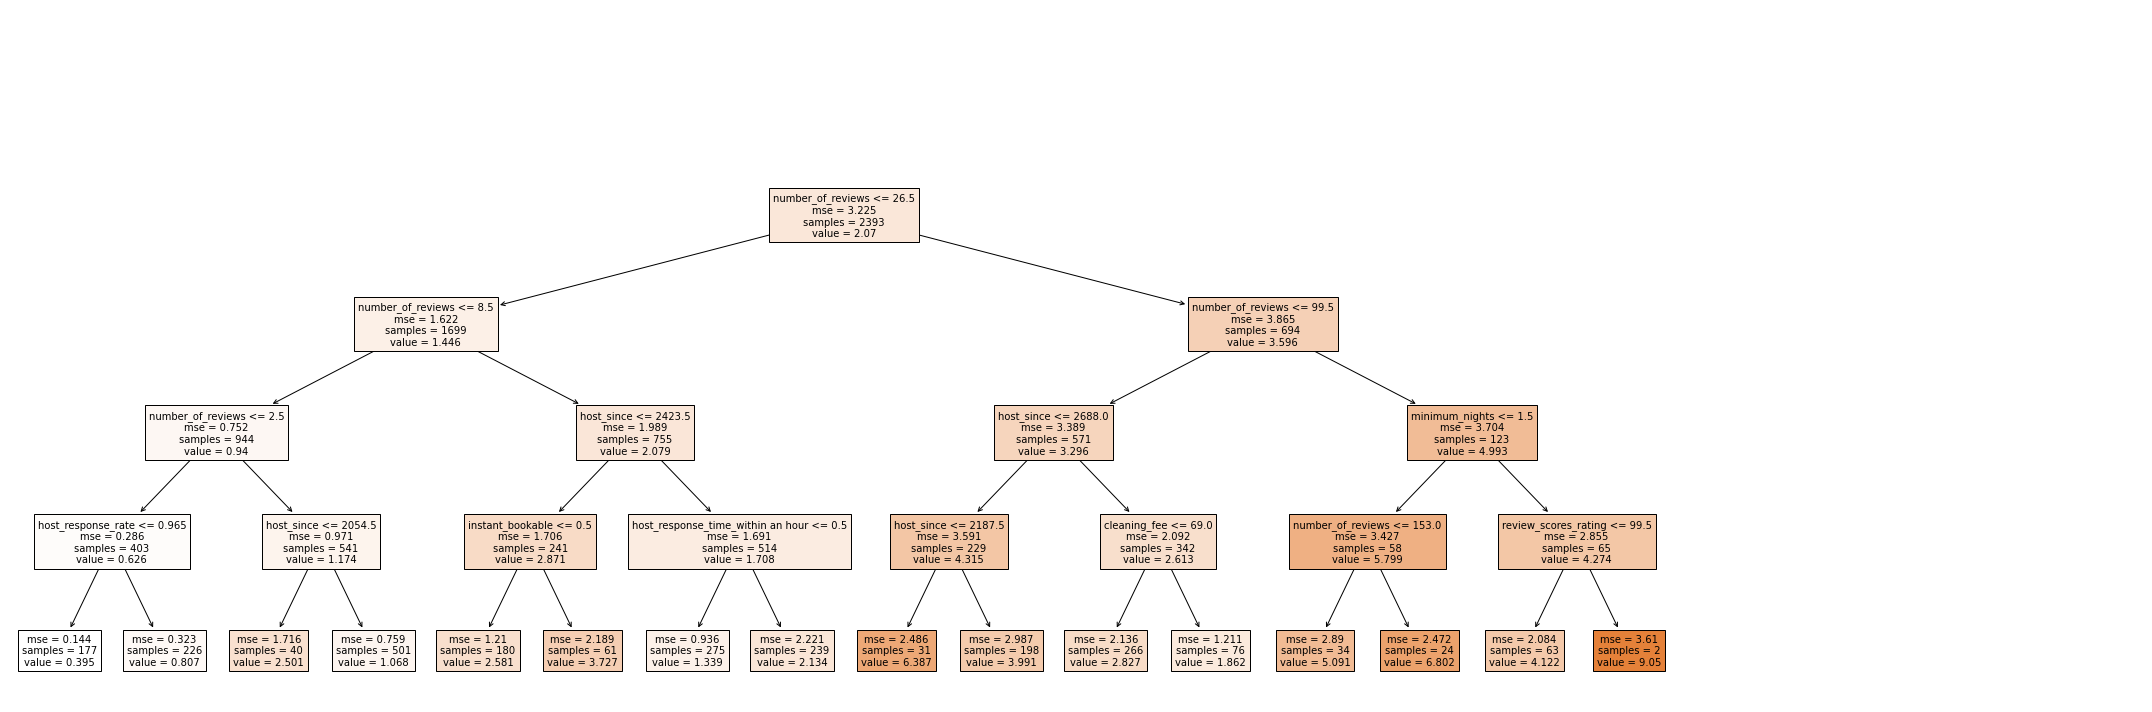

In [32]:
# Plotting the decision tree

plt.figure(figsize=(30, 10))
tree.plot_tree(dt, filled=True, fontsize=10, feature_names=X.columns);
plt.tight_layout()

In [33]:
# This is a much more stable compared to linear regression
# However, the explained variance and RMSE are not quite ideal

coeff_comparison['DT coefficients'] = dt.feature_importances_

In [34]:
coeff_comparison

,LR coefficients,DT coefficients
host_since,-0.000629,0.19279
host_response_rate,0.091693,0.00383
host_is_superhost,0.349974,0.00000
host_listings_count,-0.005905,0.00000
host_identity_verified,0.280335,0.00000
...,...,...
calendar_updated_today,1.016021,0.00000
calendar_updated_yesterday,0.793255,0.00000
cancellation_policy_flexible,-0.013309,0.00000
cancellation_policy_moderate,0.081441,0.00000


### 3. Trying Random Forest

In [36]:
from sklearn import ensemble
import time
start_time = time.time()
rf = ensemble.RandomForestRegressor(max_depth=4)
rf.fit(X_train, y_train)

predictions_rf = rf.predict(X_test)

print(f"The time taken is : {time.time() - start_time} seconds \n")
print(f"R-squared of training data is : {rf.score(X_train, y_train)}")
print(f"R-squared of test data is : {rf.score(X_test, y_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y_test, predictions_rf)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y_test, predictions_rf))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y_test, predictions_rf)}')

The time taken is : 1.385453224182129 seconds 

R-squared of training data is : 0.6348334979186347
R-squared of test data is : 0.5932759078915562 

Mean absolute error is : 0.8461270177479043
Root mean squared error is : 1.2107577941949978
Mean Absolute percentage error is : 0.8338466947514395


### 4. Trying Gradient Boost

In [37]:
import time

start_time = time.time()
gbr = ensemble.GradientBoostingRegressor(n_estimators=500,
                                     max_depth=3,
                                     )

gbr.fit(X_train, y_train)
predictions_gbr = gbr.predict(X_test)
gbr_execution_og = time.time() - start_time
print(f"The time taken is : {gbr_execution_og} seconds \n")
print(f"R-squared of training data is : {gbr.score(X_train, y_train)}")
print(f"R-squared of test data is : {gbr.score(X_test, y_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y_test, predictions_gbr)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y_test, predictions_gbr))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y_test, predictions_gbr)}')

The time taken is : 4.965423822402954 seconds 

R-squared of training data is : 0.922479680631407
R-squared of test data is : 0.7161613318081042 

Mean absolute error is : 0.707504097674035
Root mean squared error is : 1.0114469391664267
Mean Absolute percentage error is : 0.5985956751014475


### The explained variance and RMSE/MAE are much improved. However, it takes almost 5 times as much time to execute as a Random Forest

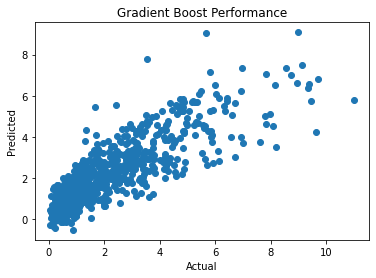

In [38]:
# Plotting the results of actual vs predicted

plt.scatter(y_test, predictions_gbr)
plt.title('Gradient Boost Performance')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Thoughts on the model performance

Gradient Boost has returned the best results so far. Before diving deeper into it and tuning, just trying out a smaller set of features, basis the coefficients returned by the Linear Regression and Decision Trees.

In [39]:
# Obtaining features with coefficients more than 0.000001 as per decision tree model

coeff_comparison[coeff_comparison['DT coefficients'] > 0.000001]['DT coefficients']

host_since                           0.192790
host_response_rate                   0.003830
cleaning_fee                         0.012509
minimum_nights                       0.016185
number_of_reviews                    0.732082
review_scores_rating                 0.010686
instant_bookable                     0.013575
host_response_time_within an hour    0.018343
Name: DT coefficients, dtype: float64

In [40]:
# Obtaining features with coefficients more than 0.0001 as per Linear Regression model

coeff_comparison[coeff_comparison['LR coefficients'] > 0.0001]['LR coefficients']

host_response_rate                       0.091693
host_is_superhost                        0.349974
host_identity_verified                   0.280335
accommodates                             0.069726
beds                                     0.009618
security_deposit                         0.000125
guests_included                          0.040268
maximum_nights                           0.000126
availability_60                          0.005370
availability_90                          0.007582
number_of_reviews                        0.023899
review_scores_accuracy                   0.106378
review_scores_cleanliness                0.025198
review_scores_checkin                    0.111183
review_scores_location                   0.103636
instant_bookable                         0.461586
require_guest_profile_picture            0.012468
calculated_host_listings_count           0.007060
host_response_time_within a few hours    0.005142
host_response_time_within an hour        0.339076


### 1. Trying a new dataset with the prominent variables from the Decision Tree model

In [41]:
cols = coeff_comparison[coeff_comparison['DT coefficients'] > 0.000001].index
X1 = X[cols]
X1

,host_since,host_response_rate,cleaning_fee,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,host_response_time_within an hour
0,3529,0.960000,34.0,1,207,95.0,0,0
1,2969,0.980000,40.0,2,43,96.0,0,1
2,2493,0.670000,300.0,4,20,97.0,0,0
4,3419,1.000000,125.0,1,38,92.0,0,1
5,3758,0.952194,40.0,1,17,95.0,0,0
...,...,...,...,...,...,...,...,...
3810,3441,1.000000,85.0,2,5,92.0,0,1
3811,2624,1.000000,20.0,1,2,100.0,0,0
3812,3142,1.000000,38.0,3,73,96.0,1,1
3813,2188,0.990000,230.0,3,1,80.0,0,0


In [42]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, random_state=129)

In [43]:
lr1 = linear_model.LinearRegression()
lr1.fit(X1_train, y1_train)

predictions_lr1 = lr1.predict(X1_test)

print(f"R-squared on training data is : {lr1.score(X1_train, y1_train)}")
print(f"R-squared on test data is : {lr1.score(X1_test, y1_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y1_test, predictions_lr1)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y1_test, predictions_lr1))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y1_test, predictions_lr1)}')

R-squared on training data is : 0.4595299888590815
R-squared on test data is : 0.5299893230628624 

Mean absolute error is : 0.9646993209535986
Root mean squared error is : 1.2890996381536612
Mean Absolute percentage error is : 1.2742806921241359


In [44]:
# Doing a cross_validation
lr1_crossval = linear_model.LinearRegression()
cross_val_lr1 = cross_val_score(lr1_crossval, X1, y, cv=5)

print(cross_val_lr1)
print(cross_val_lr1.mean())
print(cross_val_lr1.std())

[ 0.49190273  0.53052248  0.40675751 -0.70743775  0.41538099]
0.22742519076375728
0.4697387587390084


In [45]:
# Trying Decision Tree

dt1 = tree.DecisionTreeRegressor(max_depth=4)
dt1.fit(X1_train, y1_train)

predictions_dt1 = dt1.predict(X1_test)

print(f"R-squared of training data is : {dt1.score(X1_train, y1_train)}")
print(f"R-squared of test data is : {dt1.score(X1_test, y1_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y1_test, predictions_dt1)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y1_test, predictions_dt1))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y1_test, predictions_dt1)}')

R-squared of training data is : 0.5444498386796814
R-squared of test data is : 0.5635603054681149 

Mean absolute error is : 0.8952979792056202
Root mean squared error is : 1.24220921392741
Mean Absolute percentage error is : 1.0752089627295625


In [46]:
# Trying Random Forest

rf1 = ensemble.RandomForestRegressor(max_depth=4)
rf1.fit(X1_train, y1_train)

predictions_rf1 = rf1.predict(X1_test)

print(f"R-squared of training data is : {rf1.score(X1_train, y1_train)}")
print(f"R-squared of test data is : {rf1.score(X1_test, y1_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y1_test, predictions_rf1)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y1_test, predictions_rf1))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y1_test, predictions_rf1)}')

R-squared of training data is : 0.6281807349559524
R-squared of test data is : 0.6266999084230787 

Mean absolute error is : 0.824580841306629
Root mean squared error is : 1.1488456202250907
Mean Absolute percentage error is : 1.0083257728427792


In [47]:
# Trying Gradient Boost

start_time = time.time()
gbr1 = ensemble.GradientBoostingRegressor(n_estimators=500,
                                     max_depth=3,
                                     )

gbr1.fit(X1_train, y1_train)
predictions_gbr1 = gbr1.predict(X1_test)
gbr_execution_1 = time.time() - start_time
print(f"The time taken is : {gbr_execution_1} seconds \n")
print(f"R-squared of training data is : {gbr1.score(X1_train, y1_train)}")
print(f"R-squared of test data is : {gbr1.score(X1_test, y1_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y1_test, predictions_gbr1)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y1_test, predictions_gbr1))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y1_test, predictions_gbr1)}')

The time taken is : 1.2084028720855713 seconds 

R-squared of training data is : 0.8485071913437631
R-squared of test data is : 0.6889829892205586 

Mean absolute error is : 0.7123444933409872
Root mean squared error is : 1.048635838413933
Mean Absolute percentage error is : 0.6923567489846381


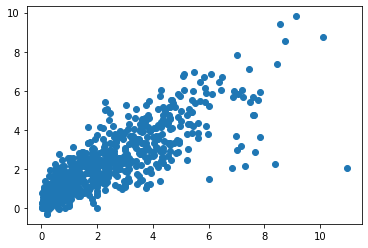

In [48]:
# PLotting the actual vs predicted value

plt.scatter(y1_test, predictions_gbr1);

### 2. Trying a new dataset with the prominent variables from the Linear Regression model

In [49]:
X2 = X[coeff_comparison[coeff_comparison['LR coefficients'] > 0.0001].index]
X2

,host_response_rate,host_is_superhost,host_identity_verified,accommodates,beds,security_deposit,guests_included,maximum_nights,availability_60,availability_90,...,calendar_updated_5 weeks ago,calendar_updated_6 days ago,calendar_updated_6 weeks ago,calendar_updated_7 months ago,calendar_updated_7 weeks ago,calendar_updated_8 months ago,calendar_updated_a week ago,calendar_updated_today,calendar_updated_yesterday,cancellation_policy_moderate
0,0.960000,0,1,4,1.0,170.0,2,365,41,71,...,0,0,0,0,0,0,0,0,0,1
1,0.980000,1,1,4,1.0,100.0,1,90,13,16,...,0,0,0,0,0,0,0,1,0,0
2,0.670000,0,1,11,7.0,1000.0,10,30,6,17,...,1,0,0,0,0,0,0,0,0,0
4,1.000000,0,1,6,3.0,700.0,6,1125,60,90,...,0,0,0,0,1,0,0,0,0,0
5,0.952194,0,1,2,1.0,240.0,1,6,0,27,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,1.000000,0,1,5,3.0,150.0,4,14,43,73,...,0,0,0,0,0,0,0,0,0,0
3811,1.000000,0,1,3,1.0,130.0,1,1125,10,13,...,0,0,0,0,0,0,1,0,0,1
3812,1.000000,1,1,4,2.0,500.0,2,365,30,43,...,0,0,0,0,0,0,0,0,1,1
3813,0.990000,0,1,6,3.0,718.0,1,1125,32,32,...,0,0,0,0,0,0,0,1,0,0


In [50]:
# splitting into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state=200)

In [51]:
# Trying Linear Regression

lr2 = linear_model.LinearRegression()
lr2.fit(X2_train, y2_train)

predictions_lr2 = lr2.predict(X2_test)

print(f"R-squared on training data is : {lr2.score(X2_train, y2_train)}")
print(f"R-squared on test data is : {lr2.score(X2_test, y2_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y2_test, predictions_lr2)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y2_test, predictions_lr2))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y2_test, predictions_lr2)}')

R-squared on training data is : 0.4926941850989681
R-squared on test data is : 0.4407432686567079 

Mean absolute error is : 1.0029918140233243
Root mean squared error is : 1.3850962461821543
Mean Absolute percentage error is : 1.1179508284118644


In [52]:
# Trying Decision Tree

dt2 = tree.DecisionTreeRegressor(max_depth=4)
dt2.fit(X2_train, y2_train)

predictions_dt2 = dt2.predict(X2_test)

print(f"R-squared of training data is : {dt2.score(X2_train, y2_train)}")
print(f"R-squared of test data is : {dt2.score(X2_test, y2_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y2_test, predictions_dt2)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y2_test, predictions_dt2))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y2_test, predictions_dt2)}')

R-squared of training data is : 0.508189725736965
R-squared of test data is : 0.4071031841175101 

Mean absolute error is : 1.0117677383358927
Root mean squared error is : 1.4261457145092018
Mean Absolute percentage error is : 0.9817654729730426


In [53]:
# Trying Random Forest

rf2 = ensemble.RandomForestRegressor(max_depth=4)
rf2.fit(X2_train, y2_train)

predictions_rf2 = rf2.predict(X2_test)

print(f"R-squared of training data is : {rf2.score(X2_train, y2_train)}")
print(f"R-squared of test data is : {rf2.score(X2_test, y2_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y2_test, predictions_rf2)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y2_test, predictions_rf2))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y2_test, predictions_rf2)}')

R-squared of training data is : 0.5467760790995635
R-squared of test data is : 0.4867717976060162 

Mean absolute error is : 0.9398157621400507
Root mean squared error is : 1.3268737392806216
Mean Absolute percentage error is : 0.9421221270990506


In [54]:
# Trying Gradient Boost

start_time = time.time()
gbr2 = ensemble.GradientBoostingRegressor(n_estimators=500,
                                     max_depth=3,
                                     )

gbr2.fit(X2_train, y2_train)
predictions_gbr2 = gbr2.predict(X2_test)

gbr_execution_2 = time.time() - start_time
print(f"The time taken is : {gbr_execution_2} seconds \n")
print(f"R-squared of training data is : {gbr2.score(X2_train, y2_train)}")
print(f"R-squared of test data is : {gbr2.score(X2_test, y2_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y2_test, predictions_gbr2)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y2_test, predictions_gbr2))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y2_test, predictions_gbr2)}')

The time taken is : 2.4607198238372803 seconds 

R-squared of training data is : 0.8322268424114774
R-squared of test data is : 0.5400588443131571 

Mean absolute error is : 0.885908851990584
Root mean squared error is : 1.2561036520474438
Mean Absolute percentage error is : 0.7525830614312613


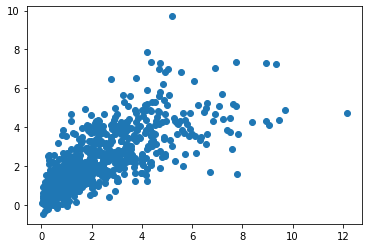

In [55]:
# Plotting the actual vs predicted values

plt.scatter(y2_test, predictions_gbr2);

In [56]:
# Comparing the model performances from the 3 datasets

performance_df = pd.DataFrame()

# Linear Regression
performance_df['LR'] = [lr.score(X_train, y_train), lr.score(X_test, y_test), 
                        mean_absolute_error(y_test, predictions_lr), np.sqrt(mean_squared_error(y_test, predictions_lr)),
                       mean_absolute_percentage_error(y_test, predictions_lr)]

performance_df['LR1'] = [lr1.score(X1_train, y1_train), lr1.score(X1_test, y1_test), 
                        mean_absolute_error(y1_test, predictions_lr1), np.sqrt(mean_squared_error(y1_test, predictions_lr1)),
                       mean_absolute_percentage_error(y1_test, predictions_lr1)]

performance_df['LR2'] = [lr2.score(X2_train, y2_train), lr2.score(X2_test, y2_test), 
                        mean_absolute_error(y2_test, predictions_lr2), np.sqrt(mean_squared_error(y2_test, predictions_lr2)),
                       mean_absolute_percentage_error(y2_test, predictions_lr2)]

# Decision Tree
performance_df['DT'] = [dt.score(X_train, y_train), dt.score(X_test, y_test), 
                        mean_absolute_error(y_test, predictions_dt), np.sqrt(mean_squared_error(y_test, predictions_dt)),
                       mean_absolute_percentage_error(y_test, predictions_dt)]

performance_df['DT1'] = [dt1.score(X1_train, y1_train), dt1.score(X1_test, y1_test), 
                        mean_absolute_error(y1_test, predictions_dt1), np.sqrt(mean_squared_error(y1_test, predictions_dt1)),
                       mean_absolute_percentage_error(y1_test, predictions_dt1)]

performance_df['DT2'] = [dt2.score(X2_train, y2_train), dt2.score(X2_test, y2_test), 
                        mean_absolute_error(y2_test, predictions_dt2), np.sqrt(mean_squared_error(y2_test, predictions_dt2)),
                       mean_absolute_percentage_error(y2_test, predictions_dt2)]

# Random Forest
performance_df['RF'] = [rf.score(X_train, y_train), rf.score(X_test, y_test), 
                        mean_absolute_error(y_test, predictions_rf), np.sqrt(mean_squared_error(y_test, predictions_rf)),
                       mean_absolute_percentage_error(y_test, predictions_rf)]

performance_df['RF1'] = [rf1.score(X1_train, y1_train), rf1.score(X1_test, y1_test), 
                        mean_absolute_error(y1_test, predictions_rf1), np.sqrt(mean_squared_error(y1_test, predictions_rf1)),
                       mean_absolute_percentage_error(y1_test, predictions_rf1)]

performance_df['RF2'] = [rf2.score(X2_train, y2_train), rf2.score(X2_test, y2_test), 
                        mean_absolute_error(y2_test, predictions_rf2), np.sqrt(mean_squared_error(y2_test, predictions_rf2)),
                       mean_absolute_percentage_error(y2_test, predictions_rf2)]

# Gradient Boost
performance_df['GBR'] = [gbr.score(X_train, y_train), gbr.score(X_test, y_test), 
                        mean_absolute_error(y_test, predictions_gbr), np.sqrt(mean_squared_error(y_test, predictions_gbr)),
                       mean_absolute_percentage_error(y_test, predictions_gbr)]

performance_df['GBR1'] = [gbr1.score(X1_train, y1_train), gbr1.score(X1_test, y1_test), 
                        mean_absolute_error(y1_test, predictions_gbr1), np.sqrt(mean_squared_error(y1_test, predictions_gbr1)),
                       mean_absolute_percentage_error(y1_test, predictions_gbr1)]

performance_df['GBR2'] = [gbr2.score(X2_train, y2_train), gbr2.score(X2_test, y2_test), 
                        mean_absolute_error(y2_test, predictions_gbr2), np.sqrt(mean_squared_error(y2_test, predictions_gbr2)),
                       mean_absolute_percentage_error(y2_test, predictions_gbr2)]



In [57]:
performance_df.index = ['R-squared training', 'R-squared test', 'MAE', 'RMSE', 'MAPE']
performance_df

,LR,LR1,LR2,DT,DT1,DT2,RF,RF1,RF2,GBR,GBR1,GBR2
R-squared training,0.575967,0.459530,0.492694,0.570801,0.544450,0.508190,0.634833,0.628181,0.546776,0.922480,0.848507,0.832227
R-squared test,0.470794,0.529989,0.440743,0.507378,0.563560,0.407103,0.593276,0.626700,0.486772,0.716161,0.688983,0.540059
MAE,0.930490,0.964699,1.002992,0.925688,0.895298,1.011768,0.846127,0.824581,0.939816,0.707504,0.712344,0.885909
RMSE,1.381082,1.289100,1.385096,1.332490,1.242209,1.426146,1.210758,1.148846,1.326874,1.011447,1.048636,1.256104
MAPE,0.949139,1.274281,1.117951,0.848837,1.075209,0.981765,0.833847,1.008326,0.942122,0.598596,0.692357,0.752583


### Observation

- Across all the 3 datasets, Gradient Boost gives the best results.

### Continuing the analysis with the most prominent variables from the Gradient Boost model

In [58]:
coeff_comparison['GBR coefficients'] = gbr.feature_importances_
coeff_comparison

,LR coefficients,DT coefficients,GBR coefficients
host_since,-0.000629,0.19279,0.131019
host_response_rate,0.091693,0.00383,0.007592
host_is_superhost,0.349974,0.00000,0.004185
host_listings_count,-0.005905,0.00000,0.003819
host_identity_verified,0.280335,0.00000,0.001336
...,...,...,...
calendar_updated_today,1.016021,0.00000,0.007544
calendar_updated_yesterday,0.793255,0.00000,0.000986
cancellation_policy_flexible,-0.013309,0.00000,0.000292
cancellation_policy_moderate,0.081441,0.00000,0.000696


In [59]:
# Taking the best 12 variables

coeff_comparison['GBR coefficients'].sort_values(ascending=False)[0:12]

number_of_reviews                    0.506132
host_since                           0.131019
minimum_nights                       0.050063
host_response_time_within an hour    0.036012
cleaning_fee                         0.032440
availability_30                      0.027893
instant_bookable                     0.020884
availability_365                     0.014688
latitude                             0.012494
longitude                            0.011377
availability_60                      0.011107
availability_90                      0.010337
Name: GBR coefficients, dtype: float64

In [60]:
# Creating a new dataset with these 12 variables

columns_gbr = coeff_comparison['GBR coefficients'].sort_values(ascending=False)[0:12].index
X3 = X[columns_gbr]
X3.head()

,number_of_reviews,host_since,minimum_nights,host_response_time_within an hour,cleaning_fee,availability_30,instant_bookable,availability_365,latitude,longitude,availability_60,availability_90
0,207,3529,1,0,34.0,14,0,346,47.636289,-122.371025,41,71
1,43,2969,2,1,40.0,13,0,291,47.639123,-122.365666,13,16
2,20,2493,4,0,300.0,1,0,220,47.629724,-122.369483,6,17
4,38,3419,1,1,125.0,30,0,365,47.632918,-122.372471,60,90
5,17,3758,1,0,40.0,0,0,302,47.630525,-122.366174,0,27


In [61]:
# Splitting into training and test datasets

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, random_state=150)

In [62]:
# Trying Linear Regression

lr3 = linear_model.LinearRegression()
lr3.fit(X3_train, y3_train)

predictions_lr3 = lr3.predict(X3_test)

print(f"R-squared on training data is : {lr3.score(X3_train, y3_train)}")
print(f"R-squared on test data is : {lr3.score(X3_test, y3_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y3_test, predictions_lr3)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y3_test, predictions_lr3))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y3_test, predictions_lr3)}')

R-squared on training data is : 0.4984401969321093
R-squared on test data is : -0.6538057702231057 

Mean absolute error is : 1.02279921884355
Root mean squared error is : 2.3281673469275135
Mean Absolute percentage error is : 1.2573017415720313


In [63]:
# Trying Decision Tree

dt3 = tree.DecisionTreeRegressor(max_depth=4)
dt3.fit(X3_train, y3_train)

predictions_dt3 = dt3.predict(X3_test)

print(f"R-squared of training data is : {dt3.score(X3_train, y3_train)}")
print(f"R-squared of test data is : {dt3.score(X3_test, y3_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y3_test, predictions_dt3)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y3_test, predictions_dt3))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y3_test, predictions_dt3)}')

R-squared of training data is : 0.5634014200987534
R-squared of test data is : 0.4728981986168155 

Mean absolute error is : 0.9379620484018711
Root mean squared error is : 1.3143747052510846
Mean Absolute percentage error is : 0.8607112965206155


In [64]:
# Trying Random Forest

rf3 = ensemble.RandomForestRegressor(max_depth=4)
rf3.fit(X3_train, y3_train)

predictions_rf3 = rf3.predict(X3_test)

print(f"R-squared of training data is : {rf3.score(X3_train, y3_train)}")
print(f"R-squared of test data is : {rf3.score(X3_test, y3_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y3_test, predictions_rf3)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y3_test, predictions_rf3))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y3_test, predictions_rf3)}')

R-squared of training data is : 0.6364217531129408
R-squared of test data is : 0.5468067688220881 

Mean absolute error is : 0.859228040460747
Root mean squared error is : 1.2187472528323238
Mean Absolute percentage error is : 0.8415763194862748


In [65]:
# Trying Gradient Boost

start_time = time.time()
gbr3 = ensemble.GradientBoostingRegressor(n_estimators=100,
                                     max_depth=3,
                                     )

gbr3.fit(X3_train, y3_train)
predictions_gbr3 = gbr3.predict(X3_test)

gbr_execution_3 = time.time() - start_time
print(f"The time taken is : {gbr_execution_3} seconds \n")

print(f"R-squared of training data is : {gbr3.score(X3_train, y3_train)}")
print(f"R-squared of test data is : {gbr3.score(X3_test, y3_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y3_test, predictions_gbr3)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y3_test, predictions_gbr3))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y3_test, predictions_gbr3)}')

The time taken is : 0.5479390621185303 seconds 

R-squared of training data is : 0.7782598515419326
R-squared of test data is : 0.6694957759380065 

Mean absolute error is : 0.7334671095803089
Root mean squared error is : 1.0407836224427904
Mean Absolute percentage error is : 0.6416704844896397


In [66]:
performance_df['LR3'] = [lr3.score(X3_train, y3_train), lr3.score(X3_test, y3_test), 
                        mean_absolute_error(y3_test, predictions_lr3), np.sqrt(mean_squared_error(y3_test, predictions_lr3)),
                       mean_absolute_percentage_error(y3_test, predictions_lr3)]

performance_df['DT3'] = [dt3.score(X3_train, y3_train), dt3.score(X3_test, y3_test), 
                        mean_absolute_error(y3_test, predictions_dt3), np.sqrt(mean_squared_error(y3_test, predictions_dt3)),
                       mean_absolute_percentage_error(y3_test, predictions_dt3)]

performance_df['RF3'] = [rf3.score(X3_train, y3_train), rf3.score(X3_test, y3_test), 
                        mean_absolute_error(y3_test, predictions_rf3), np.sqrt(mean_squared_error(y3_test, predictions_rf3)),
                       mean_absolute_percentage_error(y3_test, predictions_rf3)]

performance_df['GBR3'] = [gbr3.score(X3_train, y3_train), gbr3.score(X3_test, y3_test), 
                        mean_absolute_error(y3_test, predictions_gbr3), np.sqrt(mean_squared_error(y3_test, predictions_gbr3)),
                       mean_absolute_percentage_error(y3_test, predictions_gbr3)]

In [67]:
performance_df = performance_df[['LR', 'LR1', 'LR2', 'LR3', 'DT', 'DT1', 'DT2', 'DT3', 'RF', 'RF1', 'RF2', 'RF3', 'GBR',
       'GBR1', 'GBR2', 'GBR3']]

# Viewing the performance of Gradient boost models across the 4 datasets

performance_df[['GBR', 'GBR1', 'GBR2', 'GBR3']]

,GBR,GBR1,GBR2,GBR3
R-squared training,0.922480,0.848507,0.832227,0.778260
R-squared test,0.716161,0.688983,0.540059,0.669496
MAE,0.707504,0.712344,0.885909,0.733467
RMSE,1.011447,1.048636,1.256104,1.040784
MAPE,0.598596,0.692357,0.752583,0.641670


In [68]:
# The time taken for each of the 4 models

print(f"Time taken for GBR : {gbr_execution_og} seconds")
print(f"Time taken for GBR1 : {gbr_execution_1} seconds")
print(f"Time taken for GBR2 : {gbr_execution_2} seconds")
print(f"Time taken for GBR3 : {gbr_execution_3} seconds")

Time taken for GBR : 4.965423822402954 seconds
Time taken for GBR1 : 1.2084028720855713 seconds
Time taken for GBR2 : 2.4607198238372803 seconds
Time taken for GBR3 : 0.5479390621185303 seconds


In [69]:
# Getting the stats of the target variable

y.describe()

count    3191.000000
mean        2.078919
std         1.822348
min         0.020000
25%         0.695000
50%         1.540000
75%         3.000000
max        12.150000
Name: reviews_per_month, dtype: float64

### Observations

- The best performing model in terms of accuracy is the one on the original dataset. with 100+ features
- However, the execution time is extremely high at close to 5 seconds
- Of the optimised models, GBR3 has the best mix of accuracy and execution time - an order of magnitude faster than 
the original model

## Tuning the model with GridSearch and RandomSearch

### Trying Grid Search CV

In [70]:
# Trying to optimise for learning rate and max_depth of the residual trees

from sklearn.model_selection import GridSearchCV

start_time = time.time()
learning_rate = [x for x in np.arange(0.1, 1, 0.1)]
max_depth = [3, 4, 5]

parameters = dict(learning_rate = learning_rate, max_depth=max_depth)
gbr_grid = ensemble.GradientBoostingRegressor(n_estimators=100)

grid = GridSearchCV(estimator=gbr_grid, param_grid=parameters, cv=3)

grid_results = grid.fit(X3_train, y3_train)
print(f"Execution time is : {time.time() - start_time} seconds")

Execution time is : 34.43618202209473 seconds


In [71]:
print(f"The best parameters are : {grid_results.best_params_} \n")
print(f"The best score is : {grid_results.best_score_}")

The best parameters are : {'learning_rate': 0.1, 'max_depth': 5} 

The best score is : 0.6890413900971321


In [72]:
grid_results.cv_results_

{'mean_fit_time': array([0.31764396, 0.42535734, 0.48542134, 0.30534498, 0.39941478,
        0.50190862, 0.38179938, 0.45253809, 0.54304624, 0.33932241,
        0.48155125, 0.51526944, 0.3024141 , 0.39229449, 0.47977233,
        0.31561963, 0.39148402, 0.48357256, 0.30281234, 0.4002289 ,
        0.48457019, 0.32893427, 0.39083441, 0.48737454, 0.30647127,
        0.39134526, 0.48033897]),
 'std_fit_time': array([0.00997478, 0.02753052, 0.00450953, 0.00513631, 0.00671873,
        0.01428211, 0.01327028, 0.01485818, 0.0068382 , 0.00905859,
        0.03589035, 0.02079584, 0.0006717 , 0.0030443 , 0.0036778 ,
        0.00716297, 0.00192071, 0.00648373, 0.001832  , 0.0077792 ,
        0.00263357, 0.01705247, 0.00179502, 0.01261194, 0.00655328,
        0.00216969, 0.002647  ]),
 'mean_score_time': array([0.00435297, 0.0041333 , 0.00493161, 0.00387152, 0.00420197,
        0.00485961, 0.00502793, 0.00479499, 0.00547671, 0.00429622,
        0.00644843, 0.00494568, 0.00366457, 0.00528256, 0.004631

In [73]:
# testing based on the best parameters from gridsearchcv

start_time = time.time()
gbr4 = ensemble.GradientBoostingRegressor(n_estimators=100,
                                     max_depth=5, learning_rate=0.1
                                     )

gbr4.fit(X3_train, y3_train)
predictions_gbr4 = gbr4.predict(X3_test)

print(f"The execution time is : {time.time()-start_time} seconds")
print(f"R-squared of training data is : {gbr4.score(X3_train, y3_train)}")
print(f"R-squared of test data is : {gbr4.score(X3_test, y3_test)} \n")

print(f'Mean absolute error is : {mean_absolute_error(y3_test, predictions_gbr4)}')
print(f'Root mean squared error is : {np.sqrt(mean_squared_error(y3_test, predictions_gbr4))}')
print(f'Mean Absolute percentage error is : {mean_absolute_percentage_error(y3_test, predictions_gbr4)}')

The execution time is : 0.7394721508026123 seconds
R-squared of training data is : 0.8869992336697035
R-squared of test data is : 0.6968814310931062 

Mean absolute error is : 0.697801042512133
Root mean squared error is : 0.9967315682637611
Mean Absolute percentage error is : 0.6153648516907071


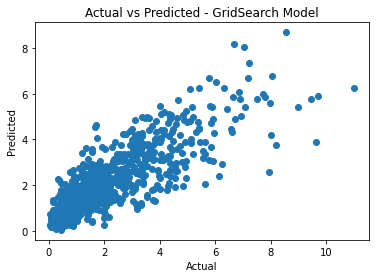

In [87]:
plt.scatter(y3_test, predictions_gbr4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - GridSearch Model')
plt.show()

In [77]:

gbr_cv = ensemble.GradientBoostingRegressor(n_estimators=100,
                                     max_depth=5, learning_rate=0.1
                                     )
gbr_cross_vals = cross_val_score(gbr_cv, X3, y, cv=5)

print(gbr_cross_vals, '\n')
print(gbr_cross_vals.mean())
print(gbr_cross_vals.std())

[0.69465851 0.70728607 0.61989013 0.68231333 0.63646122] 

0.6681218528913606
0.033965047935759884


In [78]:
# adding the result to the performance comparison dataframe

performance_df['GBR_grid'] = [gbr4.score(X3_train, y3_train), gbr4.score(X3_test, y3_test), 
                        mean_absolute_error(y3_test, predictions_gbr4), np.sqrt(mean_squared_error(y3_test, predictions_gbr4)),
                       mean_absolute_percentage_error(y3_test, predictions_gbr4)]

performance_df

<ipython-input-78-88b78521873e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_df['GBR_grid'] = [gbr4.score(X3_train, y3_train), gbr4.score(X3_test, y3_test),


,LR,LR1,LR2,LR3,DT,DT1,DT2,DT3,RF,RF1,RF2,RF3,GBR,GBR1,GBR2,GBR3,GBR_grid
R-squared training,0.575967,0.459530,0.492694,0.498440,0.570801,0.544450,0.508190,0.563401,0.634833,0.628181,0.546776,0.636422,0.922480,0.848507,0.832227,0.778260,0.886999
R-squared test,0.470794,0.529989,0.440743,-0.653806,0.507378,0.563560,0.407103,0.472898,0.593276,0.626700,0.486772,0.546807,0.716161,0.688983,0.540059,0.669496,0.696881
MAE,0.930490,0.964699,1.002992,1.022799,0.925688,0.895298,1.011768,0.937962,0.846127,0.824581,0.939816,0.859228,0.707504,0.712344,0.885909,0.733467,0.697801
RMSE,1.381082,1.289100,1.385096,2.328167,1.332490,1.242209,1.426146,1.314375,1.210758,1.148846,1.326874,1.218747,1.011447,1.048636,1.256104,1.040784,0.996732
MAPE,0.949139,1.274281,1.117951,1.257302,0.848837,1.075209,0.981765,0.860711,0.833847,1.008326,0.942122,0.841576,0.598596,0.692357,0.752583,0.641670,0.615365


### Trying Random Search CV

In [79]:
from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator=gbr_grid, param_distributions=parameters, cv=3, n_jobs=-1)

start_time = time.time()
random_result = random.fit(X3_test, y3_test)

print(f"Execution time is : {time.time() - start_time}")

Execution time is : 11.65114974975586


In [80]:
print(random_result.best_params_, '\n')
print(random_result.best_score_, '\n')

{'max_depth': 4, 'learning_rate': 0.1} 

0.5823268677001012 



### Random search has not given better results than Grid Search, so discarding the result

## Conclusion

### 1. Accuracy and Performance

In [81]:
# This is how the models compare
performance_df[['GBR', 'GBR1', 'GBR2', 'GBR3', 'GBR_grid']]

,GBR,GBR1,GBR2,GBR3,GBR_grid
R-squared training,0.922480,0.848507,0.832227,0.778260,0.886999
R-squared test,0.716161,0.688983,0.540059,0.669496,0.696881
MAE,0.707504,0.712344,0.885909,0.733467,0.697801
RMSE,1.011447,1.048636,1.256104,1.040784,0.996732
MAPE,0.598596,0.692357,0.752583,0.641670,0.615365


- Although the full dataset offers the best explainability, there are models with better accuracy and performance
- The grid search tuned model has managed to perform the best, while executing in an acceptable time of ~0.8 seconds

In [82]:
y.describe()

count    3191.000000
mean        2.078919
std         1.822348
min         0.020000
25%         0.695000
50%         1.540000
75%         3.000000
max        12.150000
Name: reviews_per_month, dtype: float64

- Assuming the target variables is notmally distributed, 99.7% of the reviews per month will be in the 0 to 7.54 range
- Since our MAE is 0.69, this is a fairly accurate model for a large % of the listed properties

### 2. Explainability

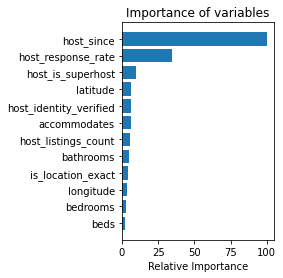

In [83]:
feature_importance = gbr4.feature_importances_
feature_importance = 100*(feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Importance of variables')
plt.show()

- We can see that the time since a property's host has been on the AirBnB platform is the largest determinant of the reviews per month
- The next best determinants are : response rate, whether the host is a superhost and whether the host's identity has been verified

### 3. Suggestions for property owners

- For existing hosts, the important things is to maintain a high response rate and maintain their verified status, in order to ensure good business.

- For new hosts, the time of listing unfortunately cannot be controlled, and is the biggest factor for getting bookings. However, they can still improve their chances by responding to booking requests quickly. They should also try to get their identity verified and reach a Superhost status as quickly as possible.